In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import datafold.pcfold as pfold

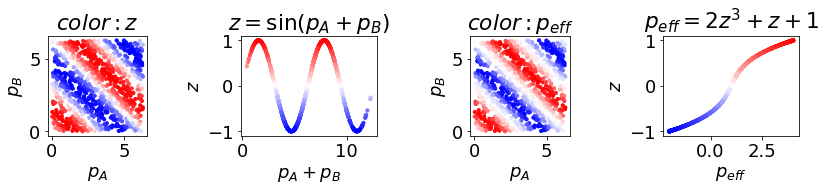

In [2]:
# simple figure 1
rng = np.random.default_rng(1)

font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

n_pts = 1000
p12 = rng.uniform(low=0,high=2*np.pi,size=(n_pts,2))
p1, p2 = p12[:,0], p12[:,1]
o1 = np.sin((p1+p2))

ell = 2*o1**3+o1+1

fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].scatter(p1,p2, s=10, c=o1, cmap="bwr");
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")
ax[0].set_title(r"$color: z$")
ax[0].set_aspect(1)

ax[1].scatter(p1+p2, o1, s=10, c=o1, cmap="bwr");
ax[1].set_xlabel(r"$p_A+p_B$")
ax[1].set_ylabel(r"$z$")
ax[1].set_title(r"$z=\sin(p_A+p_B)$")

ax[2].scatter(p1,p2, s=10, c=ell, cmap="bwr");
ax[2].set_xlabel(r"$p_A$")
ax[2].set_ylabel(r"$p_B$")
ax[2].set_title(r"$color: p_{eff}$")
ax[2].set_aspect(1)

ax[3].scatter(ell, o1, s=10, c=o1, cmap="bwr");
ax[3].set_xlabel(r"$p_{eff}$")
ax[3].set_ylabel(r"$z$")
ax[3].set_title(r"$p_{eff}=2z^3+z+1$")

fig.tight_layout();

fig.savefig("jointly_smooth_idea2.pdf")

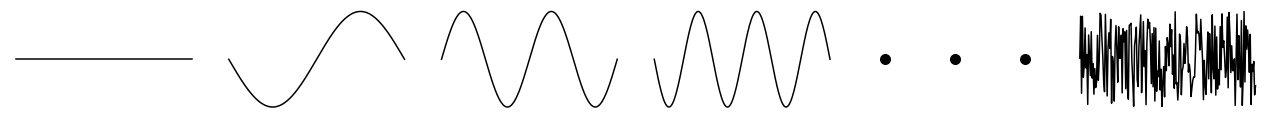

In [3]:
# figure : oscillations

rng = np.random.default_rng(1)

font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

x = np.linspace(-2*np.pi, 2*np.pi, 200)

n_plots = 6
fig,ax = plt.subplots(1,n_plots, figsize=(3*n_plots, 2), sharex=True, sharey=True)
for k in range(n_plots):
    if k < n_plots-2:
        ax[k].plot(x, np.sin(x/2*k), 'k-')
    ax[k].axis(False)
    
    if k == n_plots-2:
        ax[k].scatter([-5, 0, 5], [0,0,0], s=100,c="black")
    if k > n_plots-2:
        ax[k].plot(x,rng.uniform(low=-1,high=1,size=(len(x),)), c='black')
fig.tight_layout()
fig.savefig("smooth_functions.pdf")

In [4]:
n_pts = 15000
random_seed = 1
add = 0.4

n_kernel_evecs = 600
n_common_evecs = 10

In [5]:
def sensor1(_x,_y, div = 3, mult = 4):
    return np.column_stack([
        _x,
        _y,
        #1/3*np.sin(2*np.pi*x)
    ])
    # return np.column_stack([
    #     2*(1+1/3*np.cos(np.pi*x))*np.cos(2*np.pi*z),
    #     (1+1/3*np.cos(np.pi*x))*np.sin(2*np.pi*z),
    #     #1/3*np.sin(2*np.pi*x)
    # ])
def sensor2(_x,_z, div = 5, mult = 6):
    return np.column_stack([
        (div/2*_z+_x/2+2/3)*np.cos(mult*np.pi*_z)/2,
        (div/2*_z+_x/2+2/3)*np.sin(mult*np.pi*_z)/2
    ])


def kernelmatrix(data, eps = None, sigma = 1e-5):
    if eps is None:
        _pcm = pfold.PCManifold(data, dist_kwargs=dict(backend="guess_optimal"))
        _pcm.optimize_parameters(result_scaling=3)
    else:
        _k = pfold.kernels.GaussianKernel(eps=eps)
        _pcm = pfold.PCManifold(data, kernel=_k, dist_kwargs=dict(backend="guess_optimal"))
    res = _pcm.compute_kernel_matrix()
    
    res = res @ scipy.sparse.diags(np.array(1/res.sum(axis=0)).ravel(), 0)
    res.eliminate_zeros()
    
    print(res.nnz)
    
    return res

#from large_eigensystems import *
#import scipy
import scipy.sparse.linalg

class CommonEigensystemMatrix(scipy.sparse.linalg.LinearOperator):
    """
    Represents the common eigensystem between two large kernel matrices.
    """
    
    def __init__(self, _k1, _k2, verbose=False, kernel_evecs=100, kernel_tol=1e-15, evec_tol = 1e-6, copy=False,):
        """
        _k1, _k2: linear operators, kernel matrices representing the sensor data
        verbose: will print status if True
        kernel_evecs: maximum of kernel eigenvectors to compute. Default 100
        kernel_tol: minimum eigenvalue of the kernels to use, to compute the number of eigenvectors (max: kernel_evecs). Default 1e-15.
        evec_tol: tolerance for eigensolvers. Default 1e-6
        """
        
        self.kernel_tol = kernel_tol
        self.evec_tol = evec_tol
        self.verbose = verbose
        self.kernel_evecs = kernel_evecs
        if not copy:
            self._compute_kernel_systems(_k1, _k2)
            self.dtype = _k1.dtype
            self.shape = self.rows.shape
            self.is_adjoint = False
        
    def copy(self, deep=False):
        CEclone = CommonEigensystemMatrix(_k1=None, _k2=None, verbose=self.verbose,\
                                         kernel_evecs = self.kernel_evecs, kernel_tol=self.kernel_tol,\
                                         evec_tol=self.evec_tol, copy=True)
        CEclone.shape = self.shape
        CEclone.dtype = self.dtype
        if deep:
            CEclone.rows = self.rows.copy()
        else:
            CEclone.rows = self.rows
        return CEclone
    
    def _compute_kernel_systems(self, _k1, _k2):
        
        # use random initial state
        v0 = np.random.rand(_k1.shape[0],)
        
        if self.verbose:
            print('computing first eigensystem... ', end="")
        
        # solve both kernel problems
        n_evecs = np.min([self.kernel_evecs, _k1.shape[0]])
        Aevals,Aevecs = scipy.sparse.linalg.eigsh(_k1, k=n_evecs, v0=v0, which='LA', tol=self.evec_tol)
        Aevals,Aevecs = self._sort_eigensystem(Aevals, Aevecs)
        Aevecs = Aevecs[:,Aevals > self.kernel_tol]
        Aevals = Aevals[Aevals > self.kernel_tol]
        if self.verbose:
            print('done')
            print('computing second eigensystem... ', end="")
        
        Bevals,Bevecs = scipy.sparse.linalg.eigsh(_k2, k=n_evecs, v0=v0, which='LA', tol=self.evec_tol)
        Bevals,Bevecs = self._sort_eigensystem(Bevals, Bevecs)
        Bevecs = Bevecs[:,Bevals > self.kernel_tol]
        Bevals = Bevals[Bevals > self.kernel_tol]
        
        if self.verbose:
            print('done')
        
        n_kernels = 2 # only two up to now
        self.rows = np.column_stack([Aevecs, Bevecs]) / np.sqrt(n_kernels)
        
    def _sort_eigensystem(self, evals,evecs):
        idx = np.argsort(np.abs(evals))[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]
        return evals,evecs
    
    def _matvec(self, v):
        if self.is_adjoint:
            return self.rows.T @ v
        else:
            return self.rows @ v
        
    def _adjoint(self):
        adj = self.copy()
        adj.shape = (adj.shape[1], adj.shape[0])
        adj.is_adjoint = True
        return adj
    

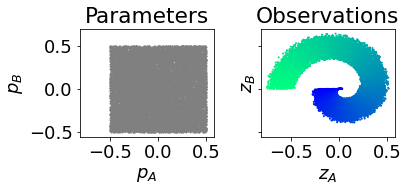

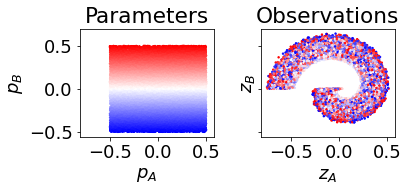

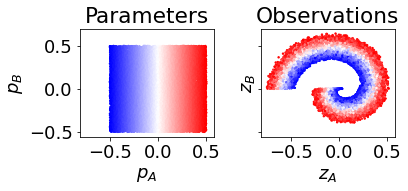

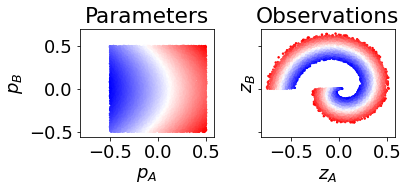

In [9]:
rng = np.random.default_rng(random_seed)

xyz = rng.uniform(low=-.5,high=.5,size=(n_pts,3))
x,y,z = xyz[:,0].reshape(-1,1), xyz[:,1].reshape(-1,1), xyz[:,2].reshape(-1,1)


s1 = sensor1(x,y,3,3)

omega = z[:,0]
peff = s1[:,0]+1*s1[:,1]**2

s2 = sensor2(peff,z[:,0],2,2)

cmap1 = "winter"
cmap2 = "bwr"


idx_plot = np.arange(0,15000)
m_s = 2

fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=1,c="gray", cmap="gray")
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=1,c=omega[idx_plot,], cmap=cmap1)
ax[1].set_title("Observations");
#ax[1].set_zlim([-1,1])
#ax[1].view_init(40,60)
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
fig.savefig("jointly_smooth_idea_x1.png")


fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=s1[idx_plot,1].ravel(), cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=m_s,c=s1[idx_plot,1].ravel(), cmap=cmap2)
ax[1].set_title("Observations");
#ax[1].set_zlim([-1,1])
#ax[1].view_init(40,60)
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
fig.savefig("jointly_smooth_idea_x2.png")

fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=s1[idx_plot,0].ravel(), cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=m_s,c=s1[idx_plot,0].ravel(), cmap=cmap2)
ax[1].set_title("Observations");
#ax[1].set_zlim([-1,1])
#ax[1].view_init(40,60)
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
fig.savefig("jointly_smooth_idea_x3.png")

fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

#ax = [fig.add_subplot(1,2,1,), fig.add_subplot(1,2,2)]#, projection="3d")]
ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=peff[idx_plot], cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=m_s,c=peff[idx_plot], cmap=cmap2)
ax[1].set_title("Observations");
#ax[1].set_zlim([-1,1])
#ax[1].view_init(40,60)
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
fig.savefig("jointly_smooth_idea_x4.png")

In [41]:
eps1=None
eps2=None

k1 = kernelmatrix(s1, eps=eps1)
k2 = kernelmatrix(s2, eps=eps2)

8574532
28432782


computing first eigensystem... done
computing second eigensystem... done
(15000, 1200)


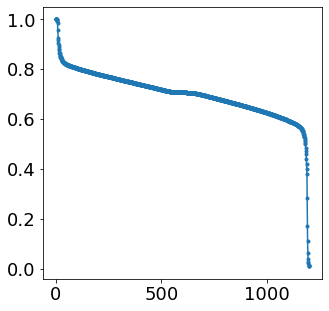

In [42]:
evec_tol = 1e-8
kernel_tol = 1e-13
verbose = True

CE = CommonEigensystemMatrix(k1,k2, kernel_tol=kernel_tol,
                             kernel_evecs=n_kernel_evecs, verbose=verbose, evec_tol=evec_tol)
print(CE.shape)
#Cevecs,Cevals,_ = scipy.sparse.linalg.svds(CE.rows, k=n_common_evecs, which='LM', tol=evec_tol)
Cevecs,Cevals,_ = scipy.linalg.svd(CE.rows)#, k=n_common_evecs, which='LM', tol=evec_tol)
Cevals,Cevecs = CE._sort_eigensystem(Cevals, Cevecs)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(Cevals,'.-')

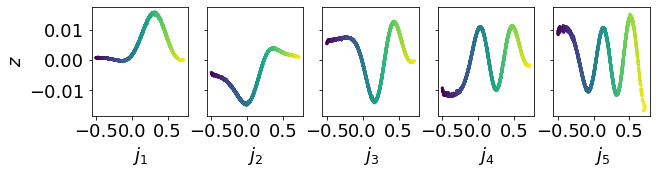

In [46]:
plot_idx = np.arange(np.min([3000, n_pts]))
n_plots = 5
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*2,2),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(peff[plot_idx,].ravel(), Cevecs[plot_idx,k],c=peff[plot_idx,], s=5)
    if k == 0:
        ax[k].set_ylabel(r"$z$")
    ax[k].set_xlabel(r"$j_"+str(k+1)+"$")
    

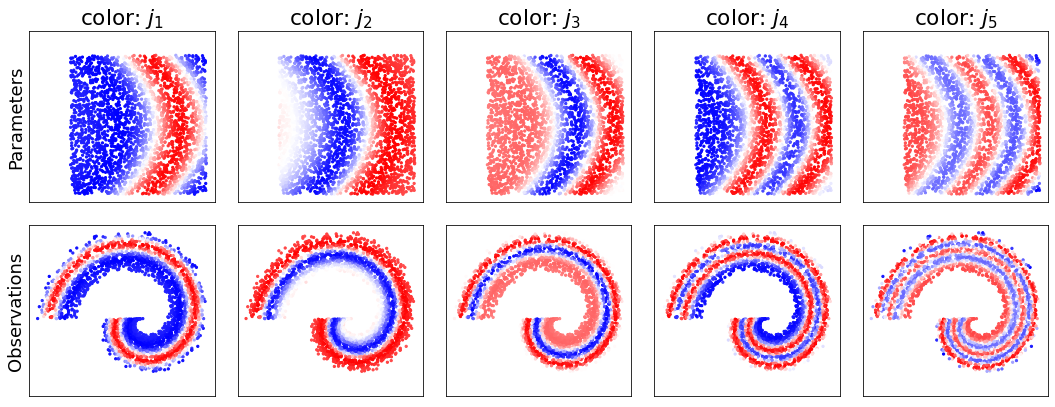

In [44]:
n_plots=5
fig,ax=plt.subplots(2,n_plots,figsize=(n_plots*3,6),sharey=True,sharex=True)
for k in range(ax.shape[1]):

    ax[0,k].scatter(*s1[plot_idx,:].T, s=5,c=Cevecs[plot_idx,k], cmap="bwr")
    if k==0:
        ax[0,k].set_ylabel("Parameters")

    ax[1,k].scatter(*s2[plot_idx,:].T, s=5,c=Cevecs[plot_idx,k], cmap="bwr")
    if k==0:
        ax[1,k].set_ylabel("Observations");
    ax[0,k].set_title(r"color: $j_"+str(k+1)+"$")
    ax[0,k].set_xticks([])
    ax[1,k].set_yticks([])

fig.tight_layout()
fig.savefig("toy_jointly_smooth.pdf")
fig.savefig("toy_jointly_smooth.png")